# Forecasting Models Experiments
### Industrial Engineering Final Project - Ariel University
**Submitted by:**  
- Marina Nezhelsky 
- Eden Cohen
- Eyal Kadosh

**Github:** https://github.com/MarinaNezhelsky/Industrial-Engineering-Final-Project/tree/main
  
<img src="https://static.vecteezy.com/ti/vettori-gratis/p1/20110681-predittivo-analitica-vettore-icona-design-gratuito-vettoriale.jpg" width="300"/>
</div>

**Table of Contents**

1. [Import libraries](#section1)
2. [Explore the data](#section2)
3. [Lazy Predict](#section3)
4. [Regressors](#section4)
4. [Propht](#section5)
6. [Final results](#section6)

***Note:** This code is after the calibrations and improvements made during the project, so it only shows the final results. 

---

<a id='section1'></a>
## Import libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import warnings
import logging
import sys
import contextlib
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


---
<a id='section2'></a>
## Explore the data

In [2]:
url = "https://raw.githubusercontent.com/MarinaNezhelsky/Industrial-Engineering-Final-Project/main/Data/Monthly_Demand_Trend_AccurateAvg.csv"
df = pd.read_csv(url)
df.head(20)

,Process,Metric,Year,Month,Monthly_Demand
0,Process 1,Demand,2020,1,2688
1,Process 1,Demand,2020,2,2956
2,Process 1,Demand,2020,3,3314
3,Process 1,Demand,2020,4,3368
4,Process 1,Demand,2020,5,3706
5,Process 1,Demand,2020,6,4155
6,Process 1,Demand,2020,7,4463
7,Process 1,Demand,2020,8,3825
8,Process 1,Demand,2020,9,4462
9,Process 1,Demand,2020,10,6015


In [3]:
df.tail(20)

,Process,Metric,Year,Month,Monthly_Demand
112,Process 3,Demand,2023,5,294
113,Process 3,Demand,2023,6,267
114,Process 3,Demand,2023,7,346
115,Process 3,Demand,2023,8,297
116,Process 3,Demand,2023,9,347
117,Process 3,Demand,2023,10,358
118,Process 3,Demand,2023,11,320
119,Process 3,Demand,2023,12,291
120,Process 3,Demand,2024,1,416
121,Process 3,Demand,2024,2,554


In [4]:
print(df.describe())

         Year  Month  Monthly_Demand
count  132.00 132.00          132.00
mean  2022.39   6.70         3133.36
std      1.36   3.46         2973.45
min   2020.00   1.00          176.00
25%   2021.00   4.00          513.25
50%   2023.00   7.00         1386.00
75%   2024.00  10.00         5949.75
max   2024.00  12.00        11209.00


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Process         132 non-null    object
 1   Metric          132 non-null    object
 2   Year            132 non-null    int64 
 3   Month           132 non-null    int64 
 4   Monthly_Demand  132 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 5.3+ KB
None


In [6]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"{column}: {df[column].nunique()} unique values")

Process: 3 unique values
Metric: 1 unique values


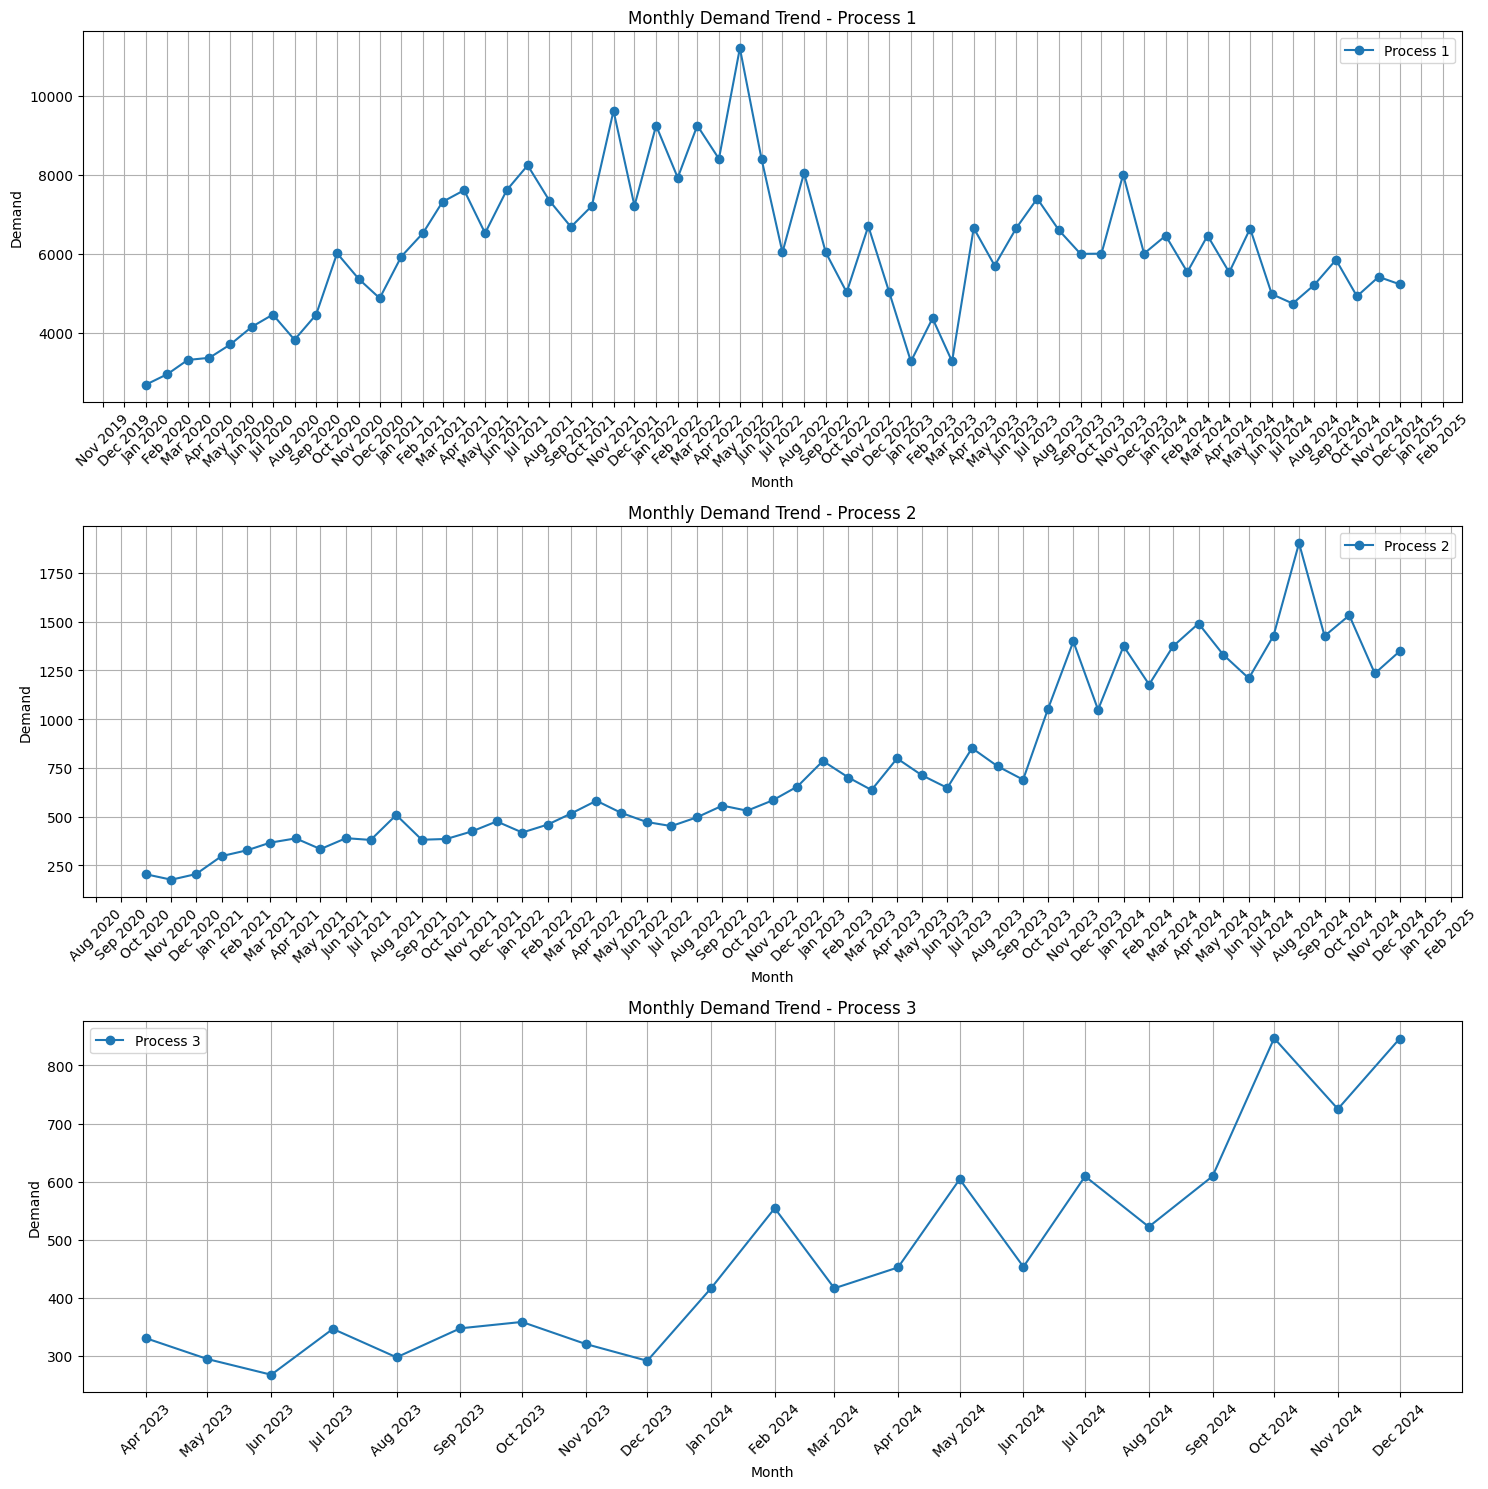

In [7]:
# Filter only rows where Metric is 'Demand'
Demand_original_df = df[df["Metric"] == "Demand"]

# Get unique processes
processes = Demand_original_df["Process"].unique()

# Set up subplots: one row per process
fig, axes = plt.subplots(nrows=len(processes), ncols=1, figsize=(15, 5 * len(processes)), sharex=False)

# Plot each process separately
for i, process in enumerate(processes):
    process_data = Demand_original_df[Demand_original_df["Process"] == process]
    process_data = process_data.sort_values(by=["Year", "Month"])
    process_data["Date"] = pd.to_datetime(dict(year=process_data["Year"], month=process_data["Month"], day=1))

    axes[i].plot(process_data["Date"], process_data["Monthly_Demand"], marker='o', label=process)
    axes[i].set_title(f"Monthly Demand Trend - {process}")
    axes[i].set_ylabel("Demand")
    axes[i].grid(True)
    axes[i].legend()

    # Format x-axis to show months for each subplot
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel("Month")

plt.tight_layout()
plt.show()


---
# Model Experiments

<a id='section3'></a>
## 1. Lazy Predict 

  0%|          | 0/42 [00:00<?, ?it/s]


🔄 Forecasting for Process: Process 1

📋 Models Used by LazyRegressor:
['PoissonRegressor', 'Ridge', 'BayesianRidge', 'SGDRegressor', 'HuberRegressor', 'PassiveAggressiveRegressor', 'LassoLarsIC', 'RidgeCV', 'LassoCV', 'Lasso', 'LassoLars', 'Lars', 'LassoLarsCV', 'LinearRegression', 'TransformedTargetRegressor', 'OrthogonalMatchingPursuitCV', 'OrthogonalMatchingPursuit', 'LarsCV', 'ElasticNet', 'GradientBoostingRegressor', 'ExtraTreesRegressor', 'GammaRegressor', 'TweedieRegressor', 'LGBMRegressor', 'RandomForestRegressor', 'HistGradientBoostingRegressor', 'ElasticNetCV', 'BaggingRegressor', 'AdaBoostRegressor', 'XGBRegressor', 'DecisionTreeRegressor', 'NuSVR', 'DummyRegressor', 'KNeighborsRegressor', 'SVR', 'QuantileRegressor', 'RANSACRegressor', 'ExtraTreeRegressor', 'GaussianProcessRegressor', 'LinearSVR', 'MLPRegressor', 'KernelRidge']
📊 Top 5 Models:
                  R-Squared   RMSE  Time Taken
Model                                         
PoissonRegressor       0.57 403.40    

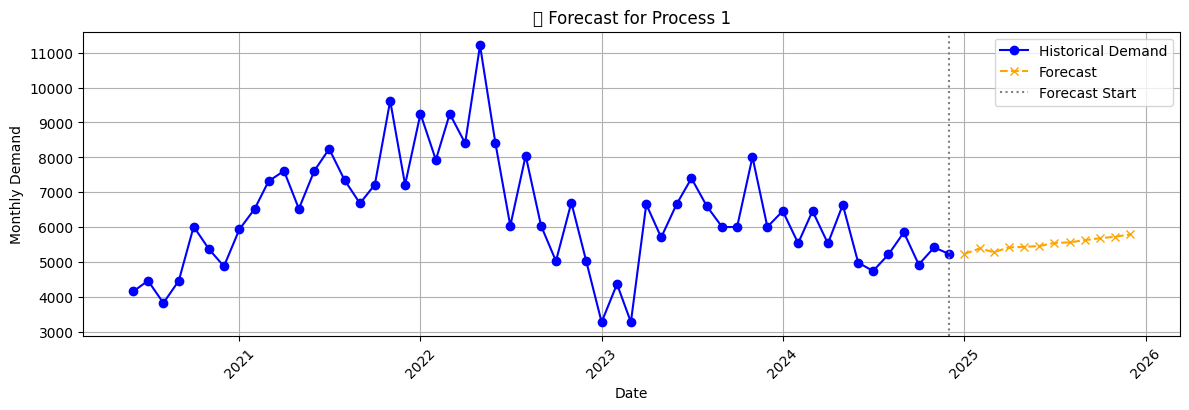

  0%|          | 0/42 [00:00<?, ?it/s]


🔄 Forecasting for Process: Process 2

📋 Models Used by LazyRegressor:
['ElasticNetCV', 'OrthogonalMatchingPursuit', 'RANSACRegressor', 'HuberRegressor', 'ElasticNet', 'ExtraTreeRegressor', 'LarsCV', 'Ridge', 'PassiveAggressiveRegressor', 'TweedieRegressor', 'SGDRegressor', 'BaggingRegressor', 'GammaRegressor', 'Lasso', 'LassoLars', 'Lars', 'LassoLarsCV', 'TransformedTargetRegressor', 'LinearRegression', 'LassoCV', 'BayesianRidge', 'RidgeCV', 'LassoLarsIC', 'OrthogonalMatchingPursuitCV', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'AdaBoostRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor', 'KernelRidge', 'HistGradientBoostingRegressor', 'DummyRegressor', 'LGBMRegressor', 'NuSVR', 'PoissonRegressor', 'QuantileRegressor', 'SVR', 'MLPRegressor', 'LinearSVR', 'GaussianProcessRegressor']
📊 Top 5 Models:
                           R-Squared   RMSE  Time Taken
Model                                                  
ElasticNetCV        

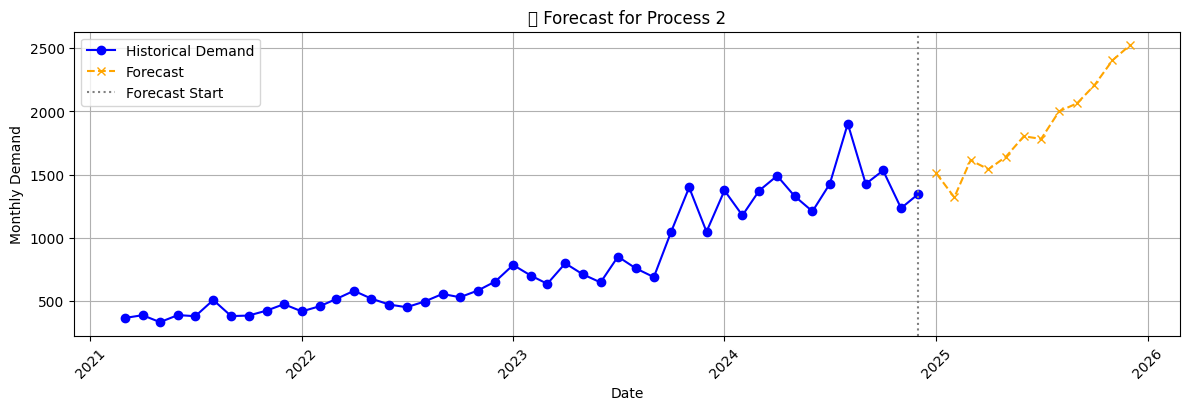

  0%|          | 0/42 [00:00<?, ?it/s]


🔄 Forecasting for Process: Process 3

📋 Models Used by LazyRegressor:
['DecisionTreeRegressor', 'SVR', 'LGBMRegressor', 'DummyRegressor', 'HistGradientBoostingRegressor', 'NuSVR', 'GradientBoostingRegressor', 'QuantileRegressor', 'AdaBoostRegressor', 'RandomForestRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 'XGBRegressor', 'ExtraTreeRegressor', 'RidgeCV', 'GammaRegressor', 'MLPRegressor', 'TweedieRegressor', 'OrthogonalMatchingPursuit', 'LassoLars', 'Lasso', 'ElasticNet', 'PoissonRegressor', 'PassiveAggressiveRegressor', 'BayesianRidge', 'LinearSVR', 'Ridge', 'GaussianProcessRegressor', 'SGDRegressor', 'Lars', 'KernelRidge', 'HuberRegressor', 'TransformedTargetRegressor', 'LinearRegression']
📊 Top 5 Models:
                               R-Squared   RMSE  Time Taken
Model                                                      
DecisionTreeRegressor              -2.88 287.00        0.01
SVR                                -3.05 293.33        0.01
LGBMRegressor                   

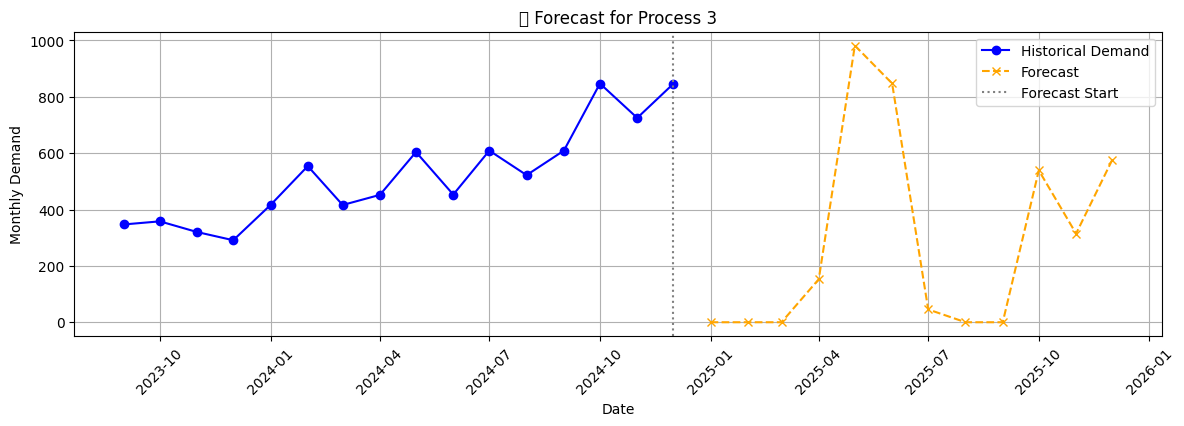


📄 Forecast Table for Process 1


,Date,Monthly_Demand,Type,Process,Time_Index
0,2024-08-01,5217.00,Actual,Process 1,NaN
1,2024-09-01,5850.00,Actual,Process 1,NaN
2,2024-10-01,4926.00,Actual,Process 1,NaN
3,2024-11-01,5418.00,Actual,Process 1,NaN
4,2024-12-01,5232.00,Actual,Process 1,NaN
5,2025-01-01,5228.66,Forecast,Process 1,60.00
6,2025-02-01,5391.45,Forecast,Process 1,61.00
7,2025-03-01,5282.50,Forecast,Process 1,62.00
8,2025-04-01,5417.27,Forecast,Process 1,63.00
9,2025-05-01,5435.50,Forecast,Process 1,64.00



📄 Forecast Table for Process 2


,Date,Monthly_Demand,Type,Process,Time_Index
0,2024-08-01,1902.00,Actual,Process 2,NaN
1,2024-09-01,1426.00,Actual,Process 2,NaN
2,2024-10-01,1532.00,Actual,Process 2,NaN
3,2024-11-01,1234.00,Actual,Process 2,NaN
4,2024-12-01,1347.00,Actual,Process 2,NaN
5,2025-01-01,1509.19,Forecast,Process 2,51.00
6,2025-02-01,1319.73,Forecast,Process 2,52.00
7,2025-03-01,1613.18,Forecast,Process 2,53.00
8,2025-04-01,1541.62,Forecast,Process 2,54.00
9,2025-05-01,1640.19,Forecast,Process 2,55.00



📄 Forecast Table for Process 3


,Date,Monthly_Demand,Type,Process,Time_Index
0,2024-08-01,522.00,Actual,Process 3,NaN
1,2024-09-01,609.00,Actual,Process 3,NaN
2,2024-10-01,847.00,Actual,Process 3,NaN
3,2024-11-01,725.00,Actual,Process 3,NaN
4,2024-12-01,846.00,Actual,Process 3,NaN
5,2025-01-01,0.00,Forecast,Process 3,21.00
6,2025-02-01,0.00,Forecast,Process 3,22.00
7,2025-03-01,0.00,Forecast,Process 3,23.00
8,2025-04-01,152.84,Forecast,Process 3,24.00
9,2025-05-01,981.89,Forecast,Process 3,25.00



🏆 Best Model per Process:


,Process,Model,Experiment,R-Squared,Adjusted R-Squared,RMSE,Time Taken (s)
0,Process 1,PoissonRegressor,Lazy Predict,0.57,0.21,403.40,0.04
1,Process 2,ElasticNetCV,Lazy Predict,0.10,-0.66,174.03,0.06
2,Process 3,DecisionTreeRegressor,Lazy Predict,-2.88,-6.11,287.00,0.01


In [8]:
os.environ["LIGHTGBM_VERBOSE"] = "0"
warnings.filterwarnings("ignore")
logging.getLogger("lightgbm").setLevel(logging.ERROR)
@contextlib.contextmanager

def suppress_stdout(): # Temporarily hides print output.
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def preprocess_data(df): # Filters for demand data and adds a time index.
    df = df[df["Metric"] == "Demand"].copy()
    df["Date"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))
    df = df.sort_values(by=["Process", "Date"])
    df["Time_Index"] = df.groupby("Process").cumcount()
    return df

def feature_engineering(sub_df): # Creates features like month, lag, and rolling averages of 3 and 6 months.
    sub_df["month"] = sub_df["Date"].dt.month
    sub_df["lag_1"] = sub_df["Monthly_Demand"].shift(1)
    sub_df["rolling_3"] = sub_df["Monthly_Demand"].rolling(3).mean()
    sub_df["rolling_6"] = sub_df["Monthly_Demand"].rolling(6).mean()
    return sub_df.dropna()

def run_lazy_regressor(X_train, X_test, y_train, y_test): # Trains multiple models and returns performance metrics.
    with suppress_stdout():
        reg = LazyRegressor(verbose=0, ignore_warnings=True)
        models, _ = reg.fit(X_train, X_test, y_train, y_test)
    print("\n📋 Models Used by LazyRegressor:")
    print(models.index.tolist())
    return models

def forecast_baseline(sub_df, model, forecast_months=12): # Predicts future demand using a model
    future_data = sub_df.copy()
    future_forecast = []
    for _ in range(forecast_months):
        last_row = future_data.iloc[-1]
        new_date = last_row["Date"] + pd.DateOffset(months=1)
        new_index = last_row["Time_Index"] + 1
        new_month = new_date.month
        lag_1 = last_row["Monthly_Demand"]
        rolling_3 = future_data["Monthly_Demand"].iloc[-3:].mean()
        rolling_6 = future_data["Monthly_Demand"].iloc[-6:].mean()
        X_future = pd.DataFrame([{
            "Time_Index": new_index,
            "month": new_month,
            "lag_1": lag_1,
            "rolling_3": rolling_3,
            "rolling_6": rolling_6
        }])
        forecast_val = model.predict(X_future)[0]
        forecast_val = max(forecast_val, 0)
        new_row = {
            "Date": new_date,
            "Time_Index": new_index,
            "Monthly_Demand": forecast_val
        }
        future_data = pd.concat([future_data, pd.DataFrame([new_row])], ignore_index=True)
        future_forecast.append({**new_row, "Type": "Forecast"})
    return pd.DataFrame(future_forecast)

def plot_forecast(sub_df, forecast_df, process): # Plots historical and forecasted demand.
    plt.figure(figsize=(12, 4))
    plt.plot(sub_df["Date"], sub_df["Monthly_Demand"], label="Historical Demand", marker="o", color="blue")
    plt.plot(forecast_df["Date"], forecast_df["Monthly_Demand"], label="Forecast", linestyle="--", marker="x", color="orange")
    plt.axvline(sub_df["Date"].max(), linestyle=":", color="gray", label="Forecast Start")
    plt.title(f"📈 Forecast for {process}")
    plt.xlabel("Date")
    plt.ylabel("Monthly Demand")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

def process_forecast(df): # Processes and forecasts data for each process, plotting results.
    all_forecasts = {}
    top5_models_dict = {}
    top3_final_models_dict = {}
    for process in df["Process"].unique():
        print(f"\n🔄 Forecasting for Process: {process}")
        sub_df = df[df["Process"] == process].copy()
        sub_df = feature_engineering(sub_df)
        X = sub_df[["Time_Index", "month", "lag_1", "rolling_3", "rolling_6"]]
        y = sub_df["Monthly_Demand"]
        X_train, X_test = X[:-12], X[-12:]
        y_train, y_test = y[:-12], y[-12:]
        models = run_lazy_regressor(X_train, X_test, y_train, y_test)
        top5_models = models.head(5).copy()
        top5_models["Process"] = process
        top5_models_dict[process] = top5_models
        top3_final_models_dict[process] = top5_models.head(3)
        print("📊 Top 5 Models:")
        print(top5_models[["R-Squared", "RMSE", "Time Taken"]])
        model = LinearRegression()
        model.fit(X_train, y_train)
        forecast_df = forecast_baseline(sub_df, model)
        forecast_df["Process"] = process
        last_actuals = sub_df[["Date", "Monthly_Demand"]].tail(5).copy()
        last_actuals["Type"] = "Actual"
        last_actuals["Process"] = process
        combined_df = pd.concat([last_actuals, forecast_df], ignore_index=True)
        all_forecasts[process] = combined_df
        plot_forecast(sub_df, forecast_df, process)
    return all_forecasts, top5_models_dict, top3_final_models_dict

def display_forecasts(all_forecasts): # Shows forecasts in a sorted table by process.
    final_df = pd.concat(all_forecasts.values(), ignore_index=True)
    final_df = final_df.sort_values(["Process", "Date"])
    for process in final_df["Process"].unique():
        print(f"\n📄 Forecast Table for {process}")
        display(final_df[final_df["Process"] == process].reset_index(drop=True))
    return final_df

def summarize_best_models(top5_models_dict): # Finds the best model per process based on metrics.
    best_model_per_process = []
    for proc, df_model in top5_models_dict.items():
        best_model = df_model.sort_values(by="R-Squared", ascending=False).head(1).copy()
        best_model["Process"] = proc
        best_model["Model"] = best_model.index[0]
        best_model["Experiment"] = "Lazy Predict"
        best_model_per_process.append(best_model)
    best_models_df = pd.concat(best_model_per_process).reset_index(drop=True)
    best_models_df = best_models_df.rename(columns={
        "R-Squared": "R-Squared",
        "Adjusted R-Squared": "Adjusted R-Squared",
        "RMSE": "RMSE",
        "Time Taken": "Time Taken (s)"
    })[["Process", "Model", "Experiment", "R-Squared", "Adjusted R-Squared", "RMSE", "Time Taken (s)"]]
    print("\n🏆 Best Model per Process:")
    display(best_models_df)
    return best_models_df

# === RUN EVERYTHING ===
df = preprocess_data(Demand_original_df)
all_forecasts, top5_models_dict, top3_final_models_dict = process_forecast(df)
final_df = display_forecasts(all_forecasts)
best_models_df = summarize_best_models(top5_models_dict)

---
<a id='section4'></a>
# 2. Regressors 

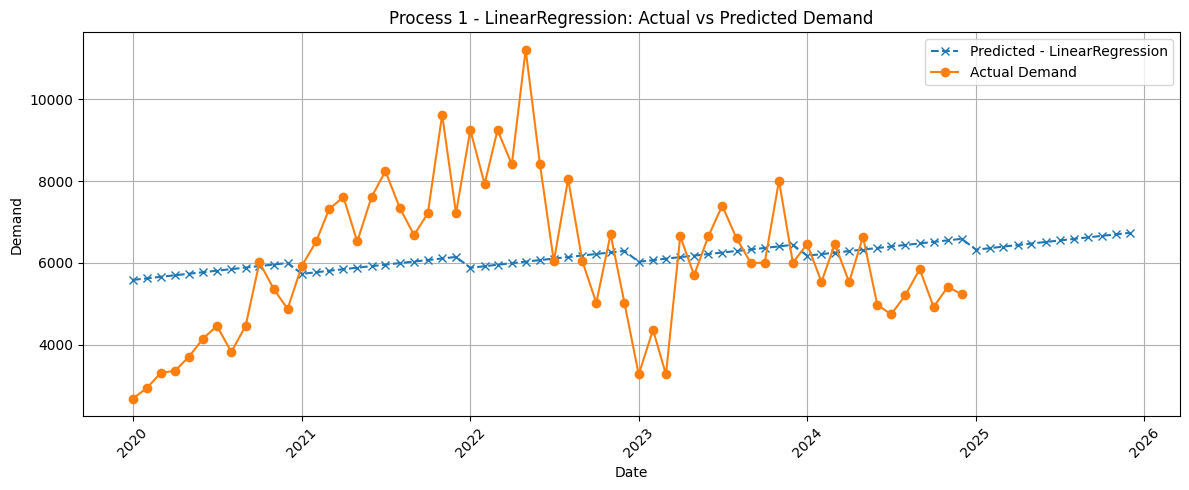

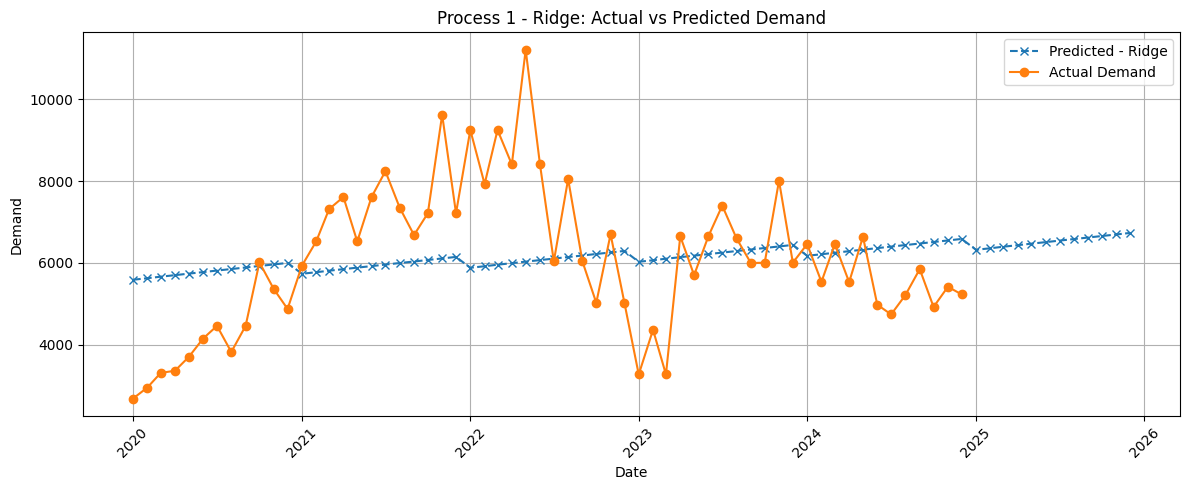

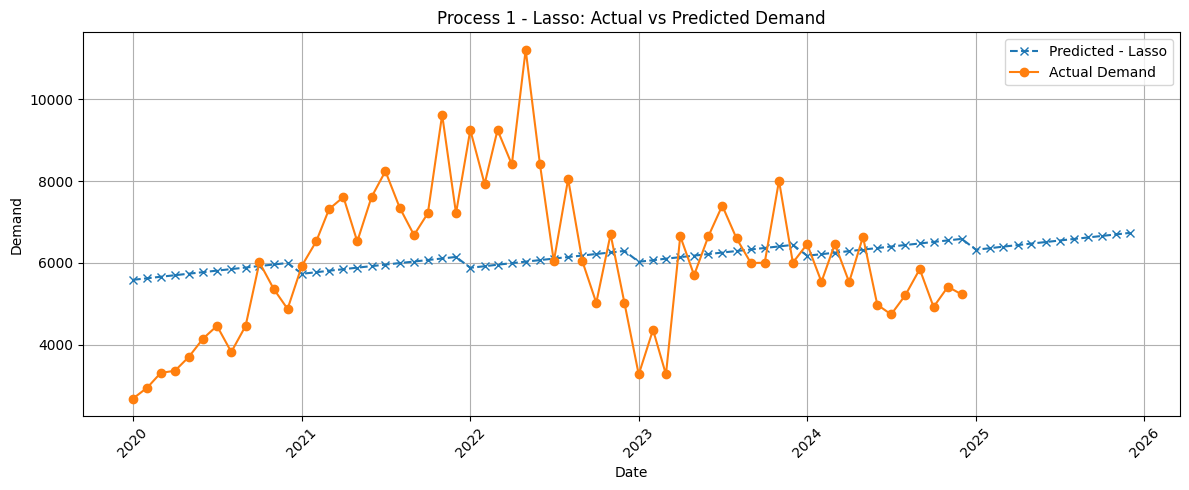

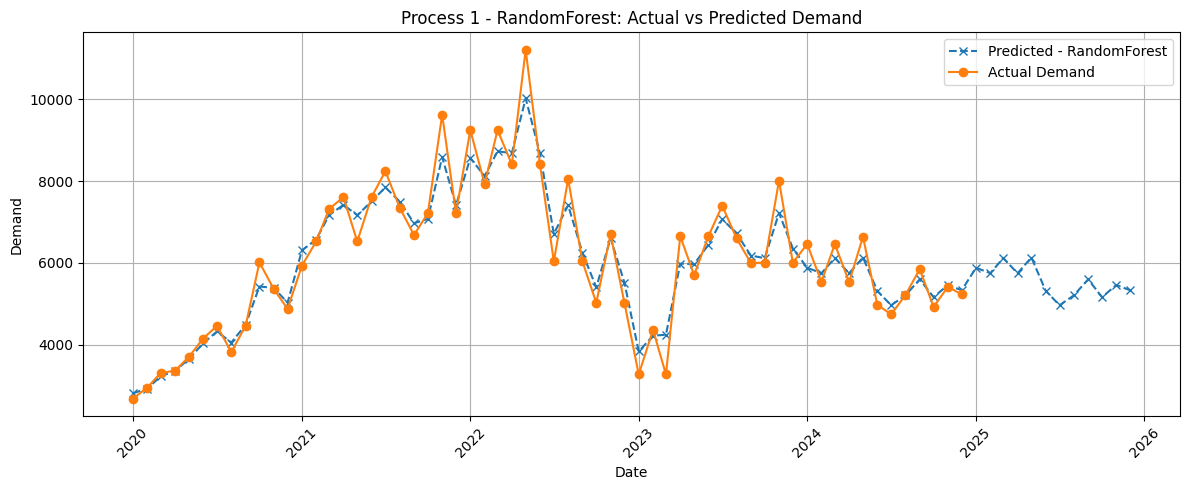

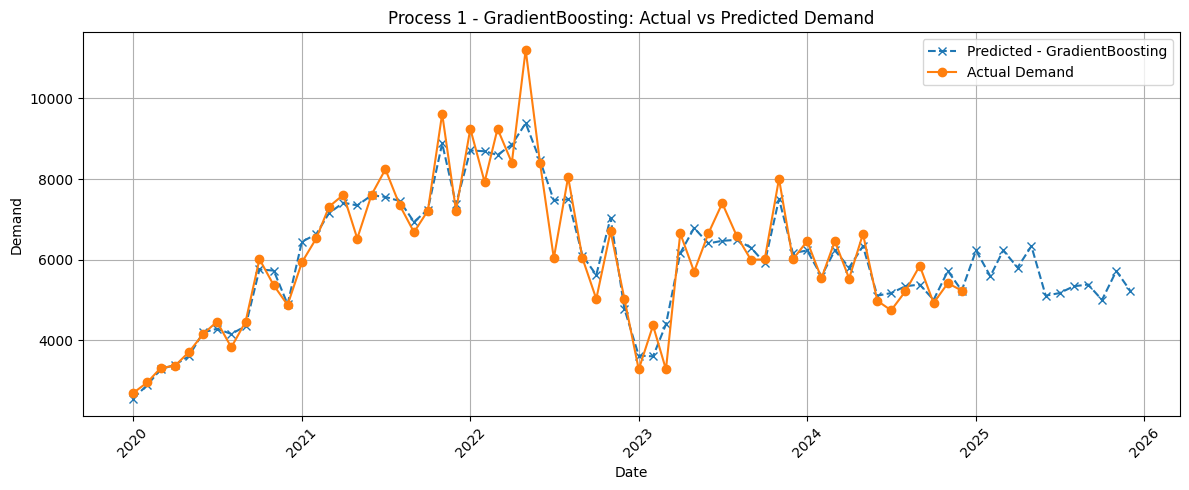

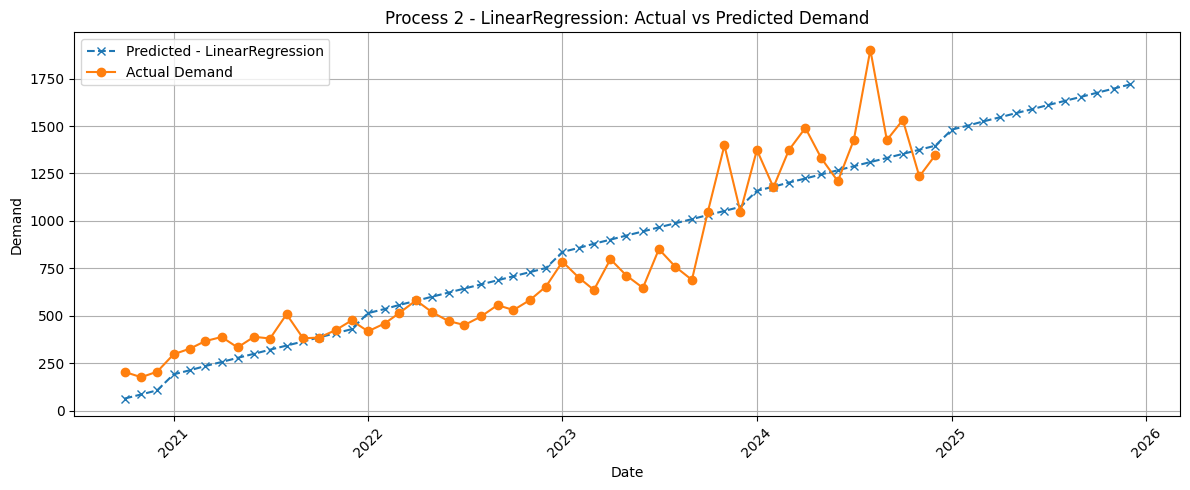

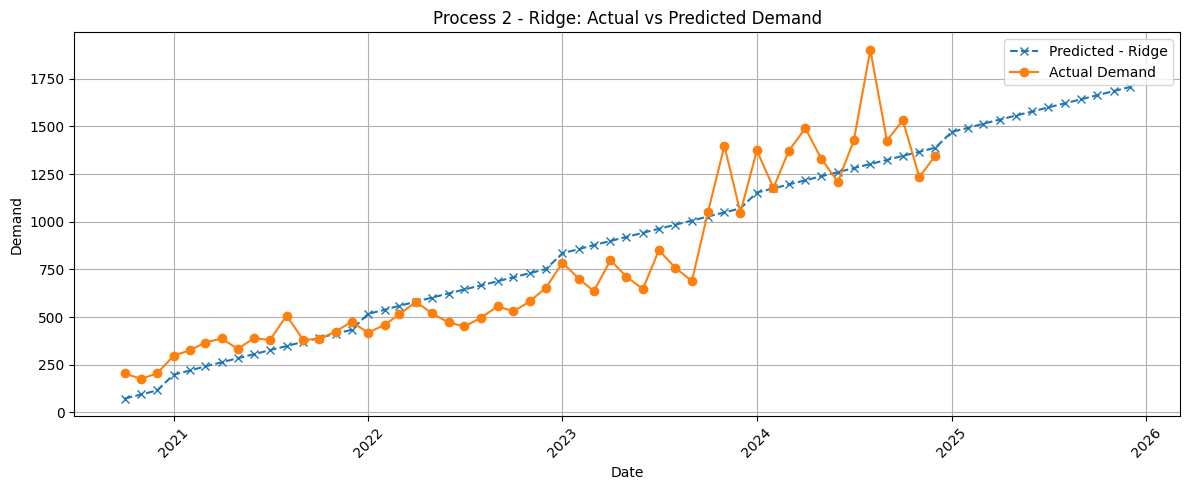

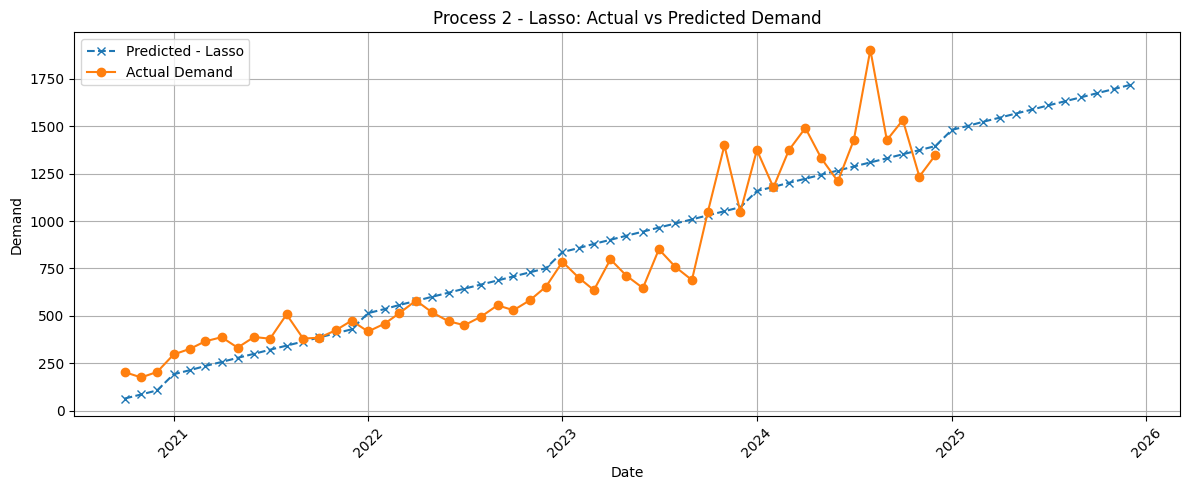

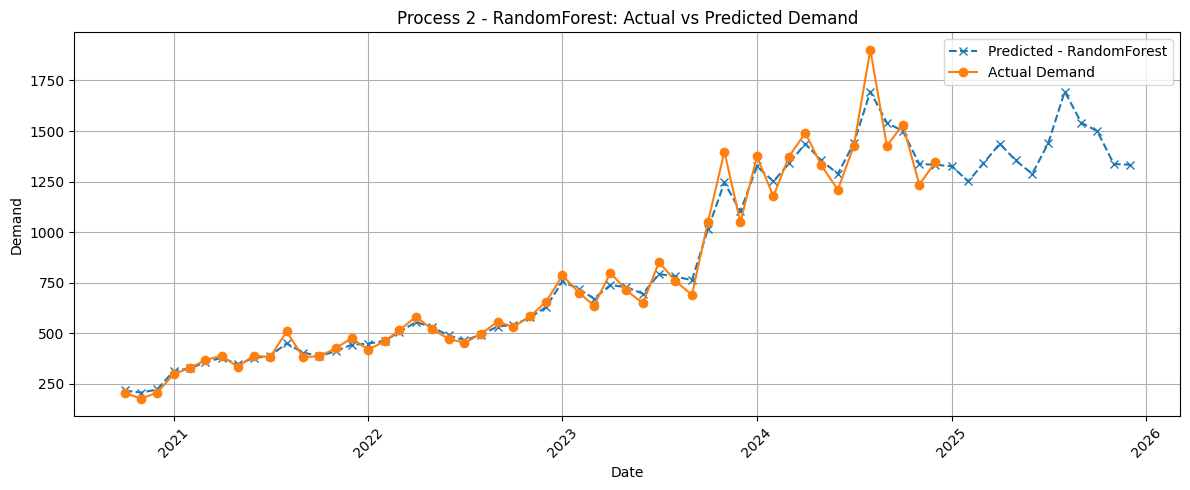

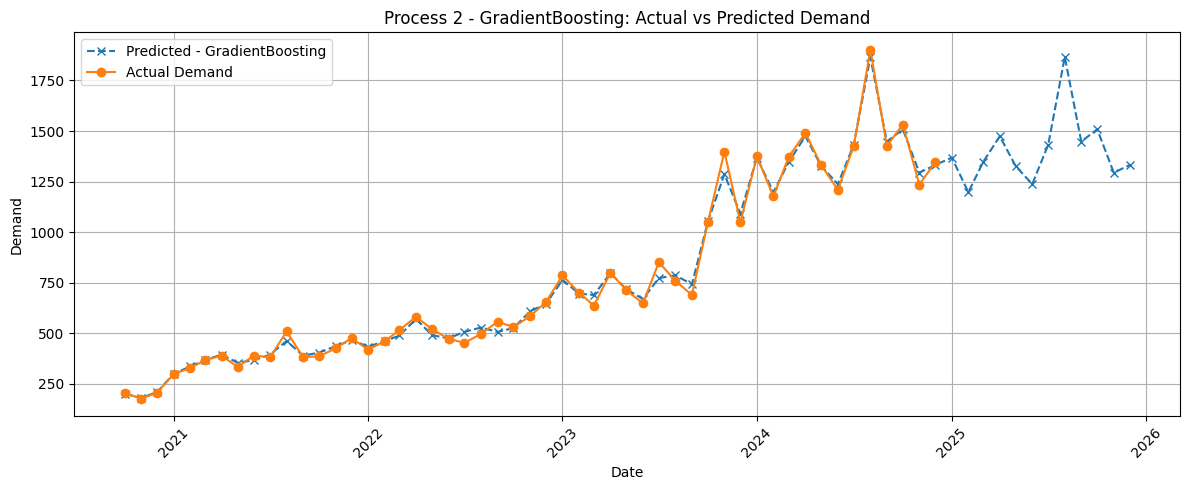

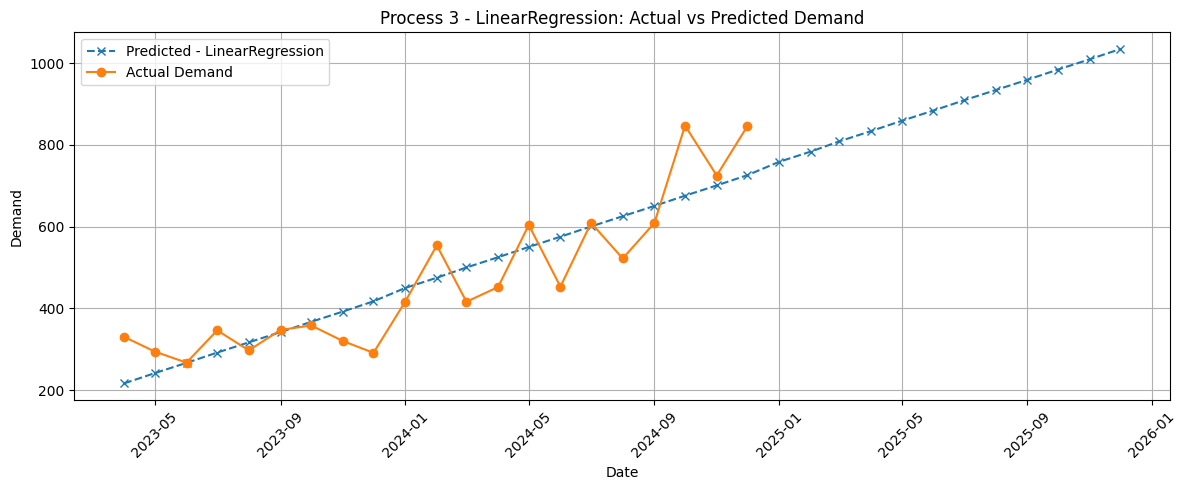

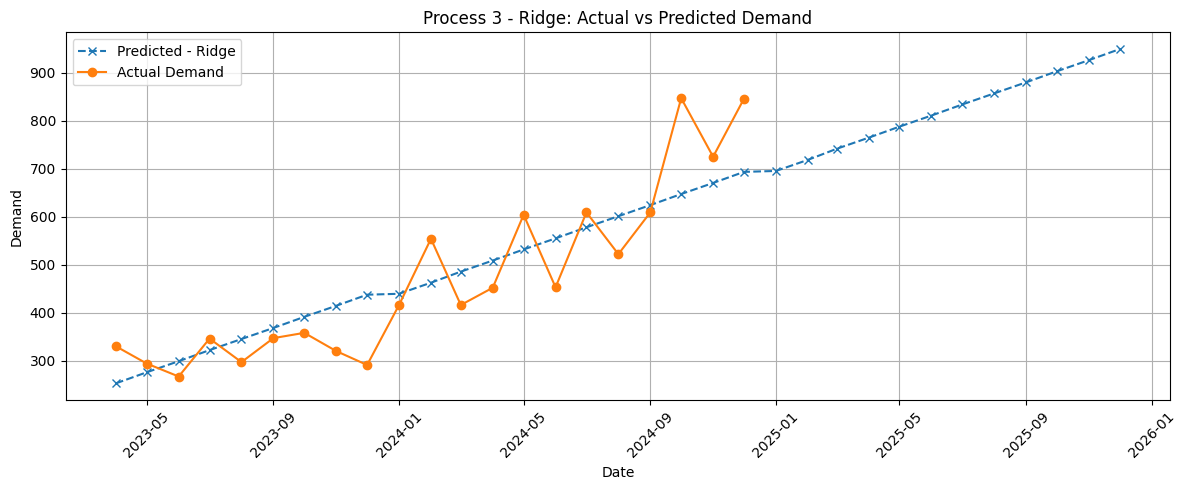

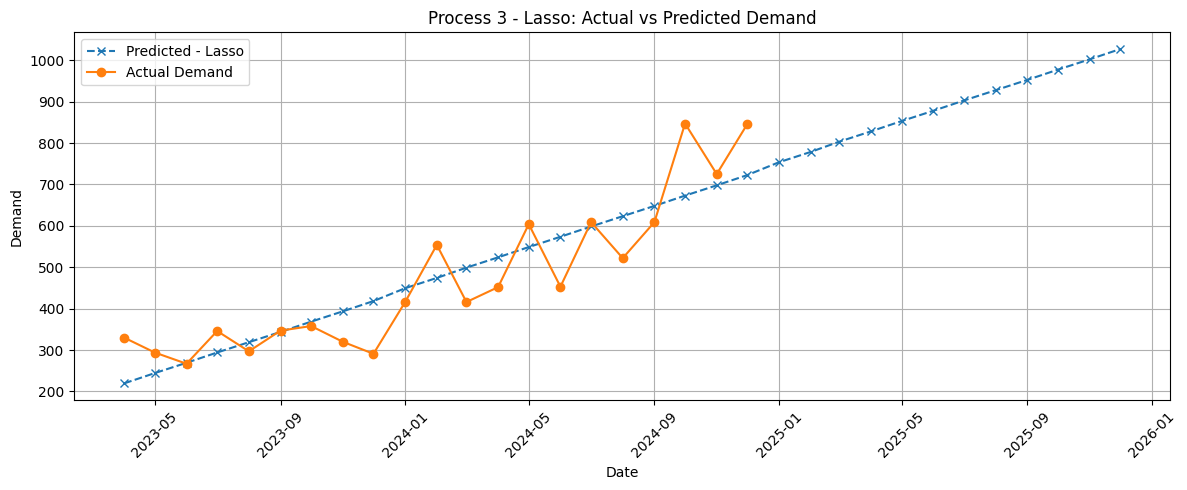

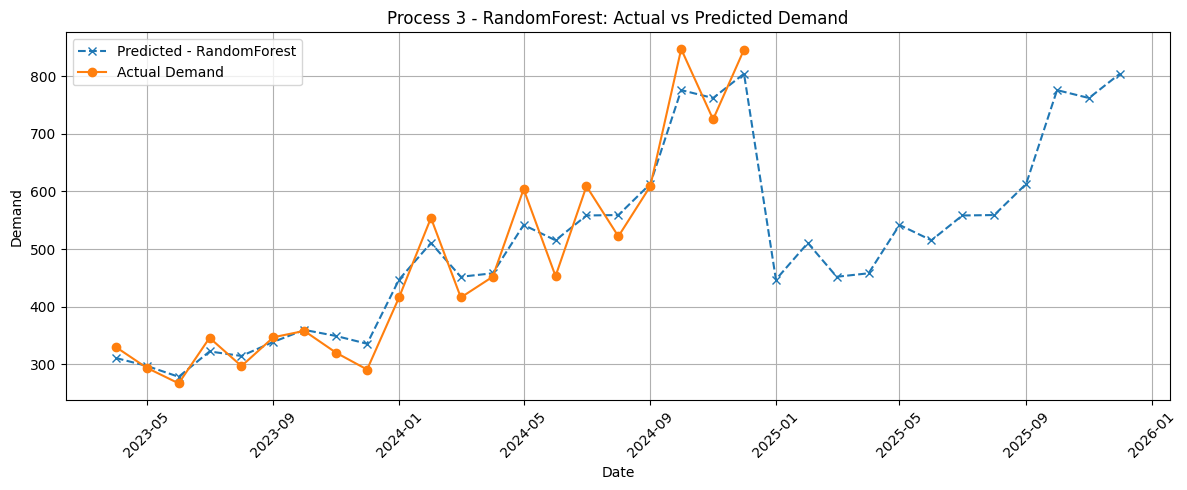

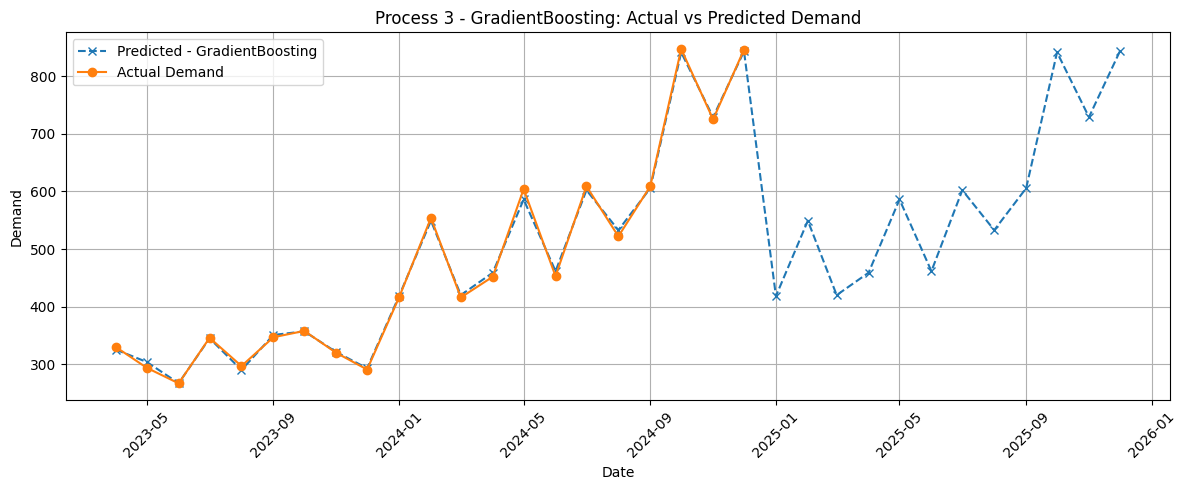

Metrics Table:


,Process,Model,R-Squared,Adjusted R-Squared,RMSE,Time Taken (s),Experiment
0,Process 1,LinearRegression,0.02,-0.01,1744.14,0.00,Regressors
1,Process 1,Ridge,0.02,-0.01,1744.14,0.01,Regressors
2,Process 1,Lasso,0.02,-0.01,1744.14,0.00,Regressors
3,Process 1,RandomForest,0.95,0.94,408.31,0.22,Regressors
4,Process 1,GradientBoosting,0.92,0.91,512.20,0.10,Regressors
5,Process 2,LinearRegression,0.85,0.84,168.13,0.00,Regressors
6,Process 2,Ridge,0.85,0.84,168.21,0.00,Regressors
7,Process 2,Lasso,0.85,0.84,168.13,0.01,Regressors
8,Process 2,RandomForest,0.98,0.98,52.87,0.21,Regressors
9,Process 2,GradientBoosting,0.99,0.99,31.12,0.09,Regressors


Best Model per Process:


,Process,Model,R-Squared,Adjusted R-Squared,RMSE,Time Taken (s),Experiment
0,Process 1,RandomForest,0.95,0.94,408.31,0.22,Regressors
1,Process 2,GradientBoosting,0.99,0.99,31.12,0.09,Regressors
2,Process 3,RandomForest,0.96,0.95,36.75,0.17,Regressors


In [9]:
#lists to store the prediction results and model evaluation
all_predictions = []
metrics_list = []

#dictionary of models to be evaluated
models_dict = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor()
}

# Loop through each unique process in the original demand DataFrame
for process in Demand_original_df["Process"].unique():
    process_data = Demand_original_df[Demand_original_df["Process"] == process].copy()    
    X = process_data[["Year", "Month"]] # Feature data
    y = process_data["Monthly_Demand"]  # Target variable
    n = len(y)
    k = X.shape[1]
    last_year = process_data["Year"].max()
    last_month = process_data[process_data["Year"] == last_year]["Month"].max()
    future_dates = []
        
    # Create dates for future predictions (next 12 months)
    for i in range(1, 13):
        new_month = last_month + i
        new_year = last_year + (new_month - 1) // 12
        new_month = ((new_month - 1) % 12) + 1
        future_dates.append((new_year, new_month))
    future_df = pd.DataFrame(future_dates, columns=["Year", "Month"])
    future_df["Monthly_Demand"] = None
    future_df["Process"] = process

    # Evaluate each model in the models dictionary
    for model_name, model in models_dict.items():
        start_time = time.time()
        model.fit(X, y) # Fit the model
        y_pred = model.predict(X) # Predict demand
        process_data[f"Predicted_{model_name}"] = y_pred
        
        # Calculate and record evaluation metrics
        r2 = r2_score(y, y_pred)
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        time_taken = round(time.time() - start_time, 4)
        metrics_list.append({
            "Process": process,
            "Model": model_name,
            "R-Squared": round(r2, 4),
            "Adjusted R-Squared": round(adj_r2, 4),
            "RMSE": round(rmse, 2),
            "Time Taken (s)": time_taken,
            "Experiment": "Regressors"
        })
        future_df_copy = future_df.copy()
        future_df_copy[f"Predicted_{model_name}"] = model.predict(future_df_copy[["Year", "Month"]])
        combined = pd.concat([process_data, future_df_copy], ignore_index=True)
        combined["Date"] = pd.to_datetime(combined["Year"].astype(str) + "-" + combined["Month"].astype(str) + "-01")
        combined["Model"] = model_name
        combined["Process"] = process
        all_predictions.append(combined)
final_df = pd.concat(all_predictions, ignore_index=True)

# Plot predictions and actual demand for each process and model
for process in final_df["Process"].unique():
    for model_name in models_dict.keys():
        subset = final_df[(final_df["Process"] == process) & (final_df["Model"] == model_name)]
        plt.figure(figsize=(12, 5))
        plt.plot(subset["Date"], subset[f"Predicted_{model_name}"], label=f"Predicted - {model_name}", linestyle='--', marker='x')
        plt.plot(subset["Date"], subset["Monthly_Demand"], label="Actual Demand", marker='o')
        plt.title(f"{process} - {model_name}: Actual vs Predicted Demand")
        plt.xlabel("Date")
        plt.ylabel("Demand")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
metrics_df = pd.DataFrame(metrics_list)
filtered_metrics_df = metrics_df[metrics_df['R-Squared'].round(2) != 1]

# Identify the best model per process based on RMSE
best_models_df1 = filtered_metrics_df.loc[filtered_metrics_df.groupby("Process")["RMSE"].idxmin()].reset_index(drop=True)
print("Metrics Table:")
display(metrics_df)
print("Best Model per Process:")
display(best_models_df1)


In [10]:
# Combine the results from the experiments
combined_df = pd.concat([best_models_df, best_models_df1], ignore_index=True)
combined_df

,Process,Model,Experiment,R-Squared,Adjusted R-Squared,RMSE,Time Taken (s)
0,Process 1,PoissonRegressor,Lazy Predict,0.57,0.21,403.40,0.04
1,Process 2,ElasticNetCV,Lazy Predict,0.10,-0.66,174.03,0.06
2,Process 3,DecisionTreeRegressor,Lazy Predict,-2.88,-6.11,287.00,0.01
3,Process 1,RandomForest,Regressors,0.95,0.94,408.31,0.22
4,Process 2,GradientBoosting,Regressors,0.99,0.99,31.12,0.09
5,Process 3,RandomForest,Regressors,0.96,0.95,36.75,0.17


---
<a id='section5'></a>
# 3. Propht

15:29:09 - cmdstanpy - INFO - Chain [1] start processing
15:29:10 - cmdstanpy - INFO - Chain [1] done processing
15:29:10 - cmdstanpy - INFO - Chain [1] start processing
15:29:10 - cmdstanpy - INFO - Chain [1] done processing
15:29:11 - cmdstanpy - INFO - Chain [1] start processing
15:29:19 - cmdstanpy - INFO - Chain [1] done processing


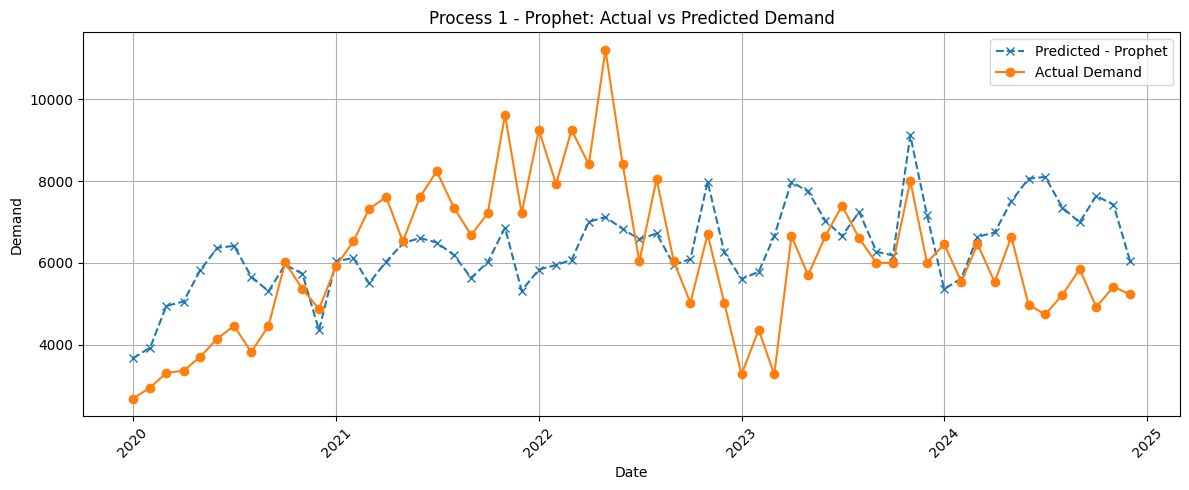

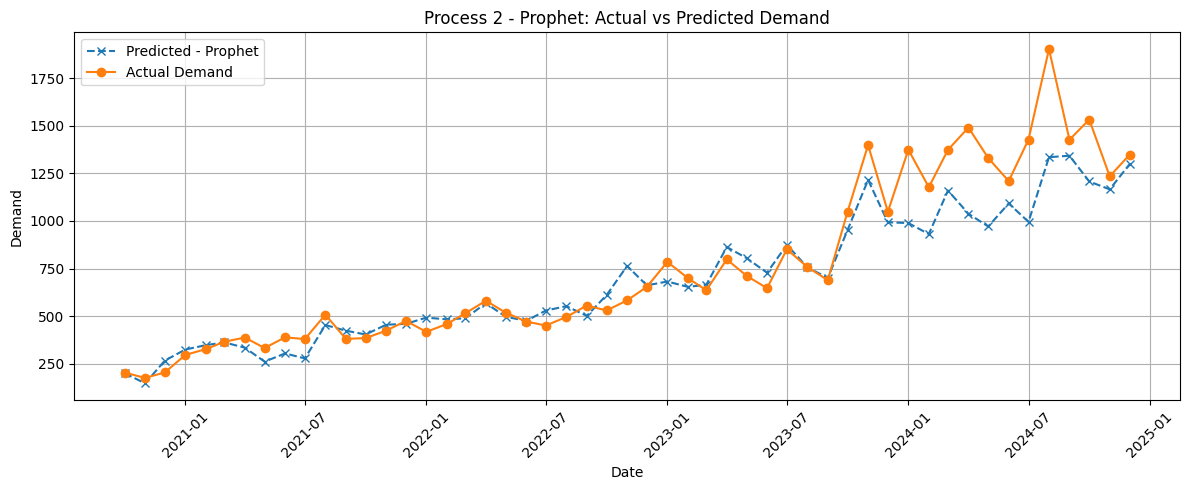

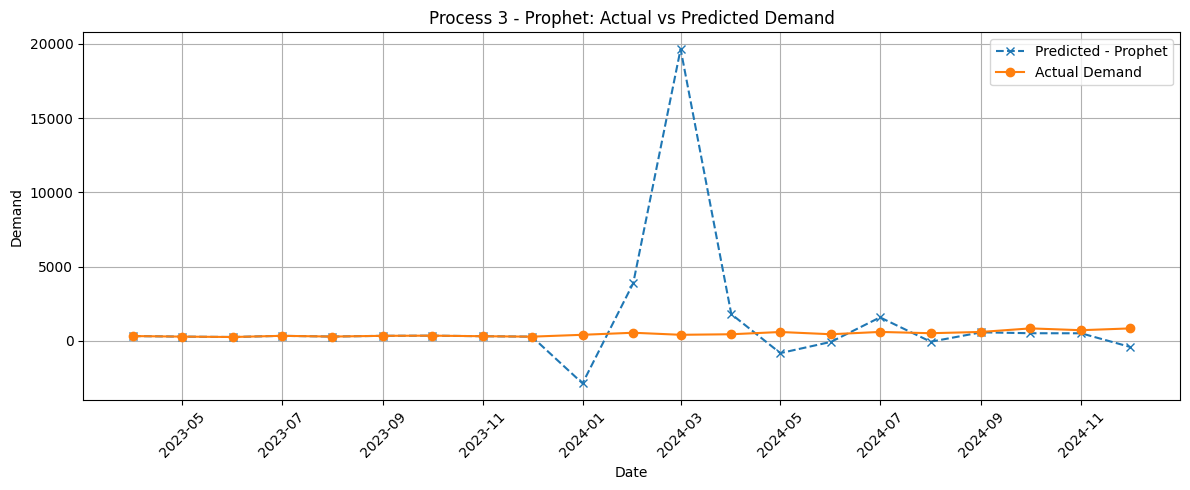

📊 Metrics Table:
      Process    Model  R-Squared  Adjusted R-Squared    RMSE  Time Taken (s)  \
0  Process 1  Prophet       0.06                0.05 1703.86            0.39   
1  Process 2  Prophet       0.85                0.85  166.08            0.35   
2  Process 3  Prophet    -621.81             -654.59 4358.70            8.19   

  Experiment  
0     Propht  
1     Propht  
2     Propht  

🏆 Best Model per Process:
      Process                  Model    Experiment  R-Squared  \
0  Process 1       PoissonRegressor  Lazy Predict       0.57   
1  Process 2           ElasticNetCV  Lazy Predict       0.10   
2  Process 3  DecisionTreeRegressor  Lazy Predict      -2.88   

   Adjusted R-Squared   RMSE  Time Taken (s)  
0                0.21 403.40            0.04  
1               -0.66 174.03            0.06  
2               -6.11 287.00            0.01  


In [12]:
# # Load and prepare data
df = Demand_original_df
df = df[df["Metric"] == "Demand"].copy()
df["Date"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))
df = df.sort_values(by=["Process", "Date"])

# Containers for predictions and metrics
all_predictions = []
metrics_list = []

# Loop through each process
for process in df["Process"].unique():
    process_df = df[df["Process"] == process].copy()
    prophet_df = process_df[["Date", "Monthly_Demand"]].rename(columns={"Date": "ds", "Monthly_Demand": "y"})

    # Split features/labels for metrics (last 12 months)
    train_df = prophet_df.iloc[:-12]
    test_df = prophet_df.iloc[-12:]

    # Train Prophet model
    model = Prophet(yearly_seasonality=True)
    start_time = time.time()
    model.fit(train_df)
    time_taken = round(time.time() - start_time, 4)

    # Predict for whole history + 12 future months
    future = model.make_future_dataframe(periods=12, freq="MS")
    forecast = model.predict(future)

    # Merge actual with predicted
    merged = pd.merge(prophet_df, forecast[["ds", "yhat"]], on="ds", how="left")

    # Metrics calculation on full history
    y_true = merged["y"].dropna()
    y_pred = merged["yhat"].dropna()
    n = len(y_true)
    p = 1
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Add metrics
    metrics_list.append({
        "Process": process,
        "Model": "Prophet",
        "R-Squared": round(r2, 4),
        "Adjusted R-Squared": round(adj_r2, 4),
        "RMSE": round(rmse, 2),
        "Time Taken (s)": time_taken,
        "Experiment":"Propht"
    })

    # Prepare full prediction DataFrame
    forecast_df = forecast[["ds", "yhat"]].rename(columns={"ds": "Date", "yhat": "Predicted_Prophet"})
    forecast_df["Process"] = process
    actual_df = prophet_df.rename(columns={"ds": "Date", "y": "Monthly_Demand"})
    actual_df["Process"] = process
    combined = pd.merge(actual_df, forecast_df, on=["Date", "Process"], how="outer")
    combined["Model"] = "Prophet"
    all_predictions.append(combined)

# Combine all results
final_df = pd.concat(all_predictions, ignore_index=True)
metrics_df = pd.DataFrame(metrics_list)

# Plot graphs per process
for process in final_df["Process"].unique():
    subset = final_df[final_df["Process"] == process]
    plt.figure(figsize=(12, 5))
    plt.plot(subset["Date"], subset["Predicted_Prophet"], label="Predicted - Prophet", linestyle='--', marker='x')
    plt.plot(subset["Date"], subset["Monthly_Demand"], label="Actual Demand", marker='o')
    plt.title(f"{process} - Prophet: Actual vs Predicted Demand")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Show results
print("📊 Metrics Table:\n", metrics_df)
best_models_df2 = metrics_df.copy()
print("\n🏆 Best Model per Process:\n", best_models_df)


---
<a id='section6'></a>
## Final Results

In [13]:
final_df = pd.concat([combined_df, best_models_df2], ignore_index=True)
final_df

,Process,Model,Experiment,R-Squared,Adjusted R-Squared,RMSE,Time Taken (s)
0,Process 1,PoissonRegressor,Lazy Predict,0.57,0.21,403.40,0.04
1,Process 2,ElasticNetCV,Lazy Predict,0.10,-0.66,174.03,0.06
2,Process 3,DecisionTreeRegressor,Lazy Predict,-2.88,-6.11,287.00,0.01
3,Process 1,RandomForest,Regressors,0.95,0.94,408.31,0.22
4,Process 2,GradientBoosting,Regressors,0.99,0.99,31.12,0.09
5,Process 3,RandomForest,Regressors,0.96,0.95,36.75,0.17
6,Process 1,Prophet,Propht,0.06,0.05,1703.86,0.39
7,Process 2,Prophet,Propht,0.85,0.85,166.08,0.35
8,Process 3,Prophet,Propht,-621.81,-654.59,4358.70,8.19


In [14]:
# Simplifying selection criteria: Sorting by Process, R-Squared descending, and RMSE ascending
best_models = final_df.sort_values(by=["Process", "R-Squared", "RMSE"], ascending=[True, False, True]).groupby("Process").first().reset_index()

print("\n Best Model per Process:")
best_models


 Best Model per Process:


,Process,Model,Experiment,R-Squared,Adjusted R-Squared,RMSE,Time Taken (s)
0,Process 1,RandomForest,Regressors,0.95,0.94,408.31,0.22
1,Process 2,GradientBoosting,Regressors,0.99,0.99,31.12,0.09
2,Process 3,RandomForest,Regressors,0.96,0.95,36.75,0.17


---
### Adjust the code to PBI visualization

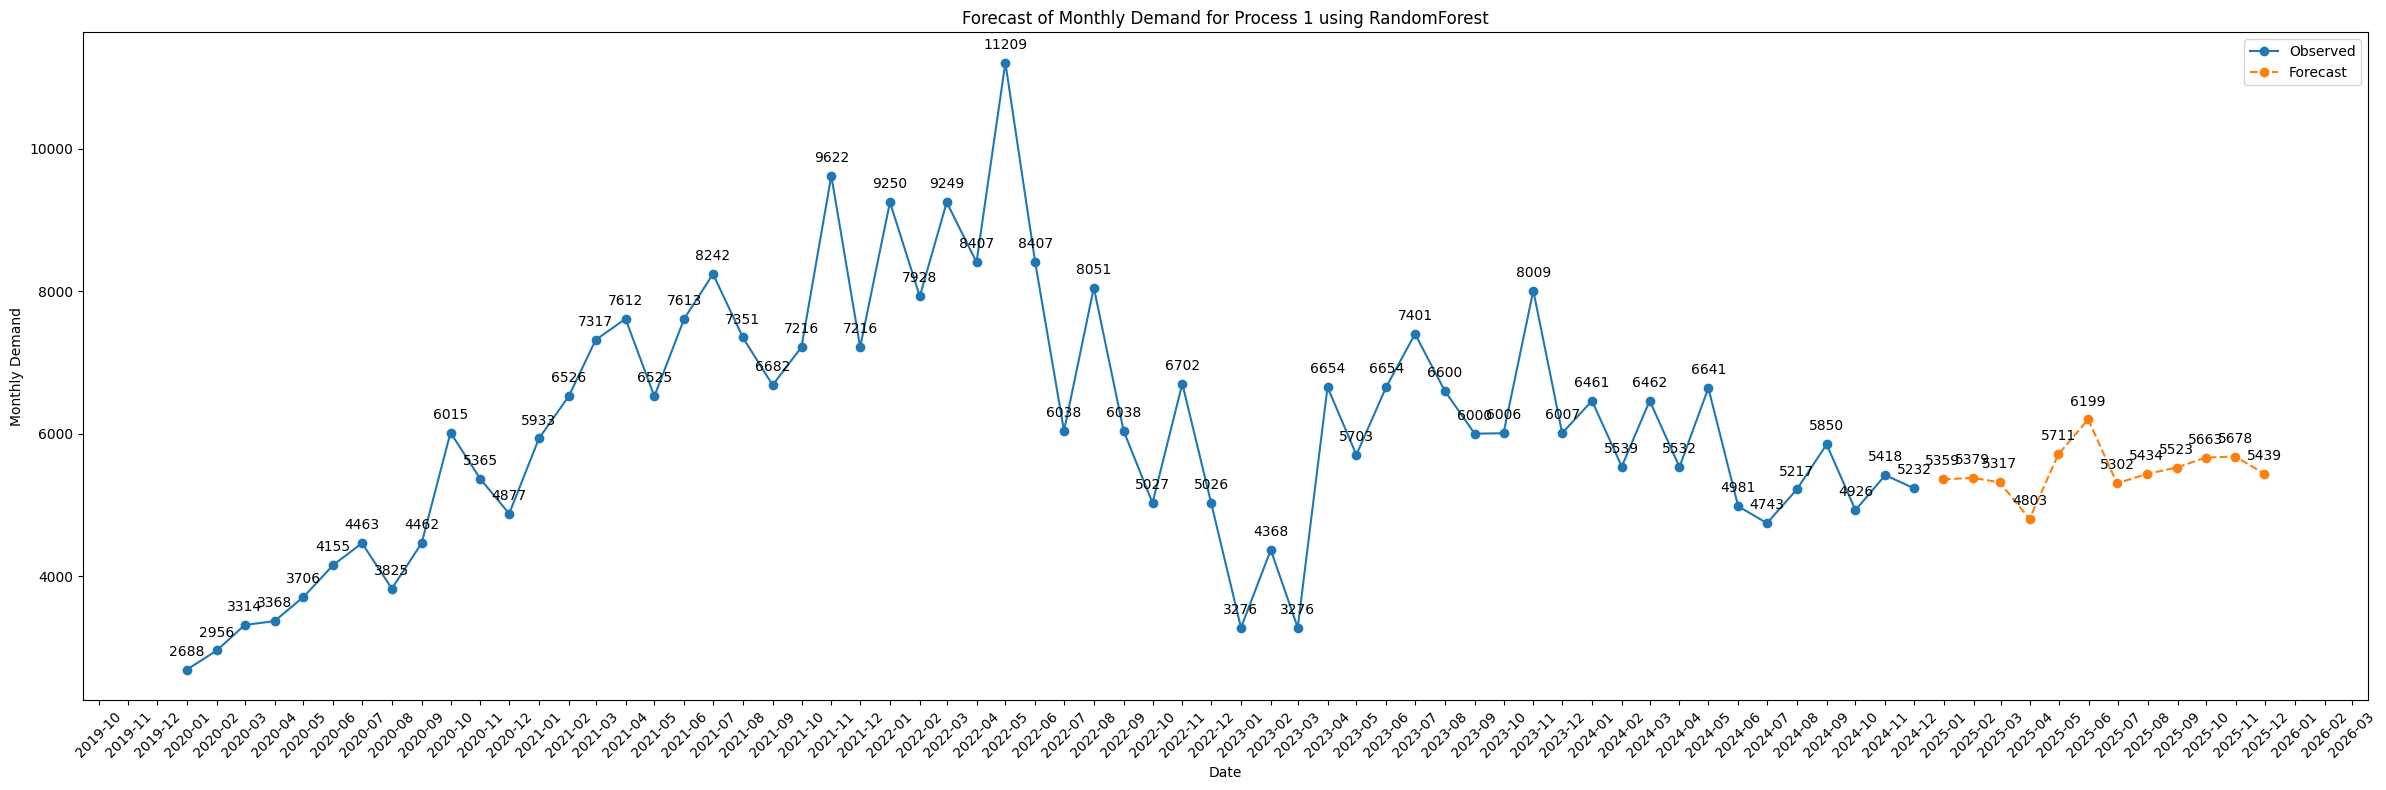

In [15]:
# dataset = pandas.DataFrame(Year, Quarter, Month, Process, Monthly_Demand)
# dataset = dataset.drop_duplicates()


# # Function to convert month names to numeric values
# def month_name_to_number(month_name):
#     month_mapper = {
#         "January": 1, "February": 2, "March": 3, "April": 4,
#         "May": 5, "June": 6, "July": 7, "August": 8,
#         "September": 9, "October": 10, "November": 11, "December": 12
#     }
#     return month_mapper[month_name]

# # Convert month names to numeric
# dataset['Month'] = dataset['Month'].apply(month_name_to_number)   

# # Ensure the data is sorted by time
# dataset.sort_values(by=['Year', 'Month'], inplace=True)

# # Create Date for time series processing
Demand_original_df['Date'] = pd.to_datetime(Demand_original_df[['Year', 'Month']].assign(DAY=1))

# Focus on one specific process
process_name = "Process 1"
process_data = Demand_original_df[Demand_original_df['Process'] == process_name]

# Check if the dataset has at least 8 observations
if len(process_data) >= 8:
    # Preparing the feature set
    X = process_data[['Year', 'Month']]
    y = process_data['Monthly_Demand']

    # Split the data into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the RandomForest model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predict the demand for the test set
    y_pred = model.predict(X_test_scaled)

    # Prepare new data for the next 12 months forecasting
    future_dates = pd.date_range(start=process_data['Date'].iloc[-1] + pd.offsets.MonthEnd(), periods=12, freq='M')
    future_X = pd.DataFrame({
        "Year": future_dates.year,
        "Month": future_dates.month
    })
    future_X_scaled = scaler.transform(future_X)

    # Forecast future demand
    forecast = model.predict(future_X_scaled)

    # Plot forecast
    plt.figure(figsize=(24, 8))
    plt.plot(process_data['Date'], process_data['Monthly_Demand'], label='Observed', marker='o')
    plt.plot(future_dates, forecast, label='Forecast', marker='o', linestyle='--')
    plt.title(f'Forecast of Monthly Demand for {process_name} using RandomForest')
    plt.xlabel('Date')
    plt.ylabel('Monthly Demand')

    # Format the x-axis to show every month and year
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

        # Add data labels for observed points
    for i, txt in enumerate(process_data['Monthly_Demand']):
        plt.annotate(txt, (process_data['Date'].iloc[i], process_data['Monthly_Demand'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Add data labels for forecasted points
    for i, txt in enumerate(forecast):
        plt.annotate(f"{int(txt)}", (future_dates[i], forecast[i]), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough data to perform RandomForest forecasting for {process_name}.")